In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import gamma
from scipy import optimize
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.outliers_influence import OLSInfluence

# MSP 2. projekt
Autor: Erika Do (xdoeri00)

<br>

## Věrohodnost

[Celkem 4 body] V souboru Data_2024.xlsx (v listu Data_věrohodnost) máte zaznamenáno, jak dlouho
po ukončení vzdělání pracují absolventi VUT ve „svém“ oboru (v letech). Někteří absolventi však po
nějaké (zaznamenané) době přestali reagovat. U těchto absolventů je znám čas kdy přerušili kontakt
(ale kdy ještě pracovali v oboru). Tato pozorování berte jako zprava cenzorovaná (jsou označena ve
sloupečku „cesored“ jedničkou). Předpokládejte, že doba zaměstnání v oboru se řídí Weibullovým
rozdělením pravděpodobnosti začínajícím v 0
(parametr prahu-threshold nastavte na 0).

### 1) Zapište zvolenou parametrizaci Weibullova rozdělení, logaritmickou-věrohodnostní funkci pro zadaná data a její parciální derivace podle parametrů (shape, scale).

#### Parametrizace Weibullova rozdělení
Weibullovo rozdělení má dva parametry: tvar ($k$) a měřítko ($\lambda$). Jeho hustota pravděpodobnosti je:

$$
f(t; k, \lambda) =
\begin{cases}
\frac{k}{\lambda} \left(\frac{t}{\lambda}\right)^{k-1} e^{-\left(\frac{t}{\lambda}\right)^k}, & t \geq 0 \\
0, & t < 0
\end{cases} $$

Kumulativní distribuční funkce (CDF) je:
$$
F(t; k, \lambda) =
\begin{cases}
1 - e^{-\left(\frac{t}{\lambda}\right)^k}, & t \geq 0 \\
0, & t < 0
\end{cases}
$$

#### Logaritmická věrohodnostní funkce
Pro data obsahující necenzorovaná a cenzorovaná pozorování lze logaritmickou věrohodnostní funkci vyjádřit následovně:

1. Necenzorovaná data ($censored = 0$):
$$
\ell_{uncensored} = \sum_{i=1}^n \log \left(\frac{k}{\lambda} \left(\frac{t_i}{\lambda}\right)^{k-1} e^{-\left(\frac{t_i}{\lambda}\right)^k}\right)
$$

$\hspace{1em}$ Což lze rozepsat jako:

$$
\ell_{uncensored} = \sum_{i=1}^n \left[\log \left(\frac{k}{\lambda}\right) + (k-1) \log \left(\frac{t_i}{\lambda}\right) - \left(\frac{t_i}{\lambda}\right)^k \right]
$$

2. Cenzorovaná data ($censored = 1$): Pro cenzorovaná data věrohodnostní funkce zahrnuje pravděpodobnost, že doba je větší než pozorovaná hodnota:
$$
\ell_{censored} = \sum_{j=1}^m \log \left(1 - F(t_j; k, \lambda)\right)
$$

$\hspace{1em}$kde
$$
F(t_j; k, \lambda) = 1 - e^{-\left(\frac{t_j}{\lambda}\right)^k}.$$

$\hspace{1em}$ Po úpravě:

$$
\ell_{censored} = \sum_{j=1}^m \log \left(e^{-\left(\frac{t_j}{\lambda}\right)^k}\right) = -\sum_{j=1}^m \left(\frac{t_j}{\lambda}\right)^k
$$

3. Celková logaritmická věrohodnostní funkce:
$$
\ell(k, \lambda) = \ell_{uncensored} + \ell_{censored}
$$

$\hspace{1em}$ Tedy:
$$
\ell(k, \lambda) = \sum_{i=1}^n \left[\log \left(\frac{k}{\lambda}\right) + (k-1) \log \left(\frac{t_i}{\lambda}\right) - \left(\frac{t_i}{\lambda}\right)^k \right]
- \sum_{j=1}^m \left(\frac{t_j}{\lambda}\right)^k
$$

#### Parciální derivace logaritmické věrohodnosti
Pro odhad parametrů je třeba spočítat parciální derivace logaritmické věrohodnosti $\ell(k, \lambda)$ podle $k$ a $\lambda$:

1. Derivace podle ($k$):

- $\frac{\partial}{\partial k} \log \left(\frac{k}{\lambda}\right) = \frac{1}{k}$
- $\frac{\partial}{\partial k} \left[(k-1) \log \left(\frac{t_i}{\lambda}\right)\right] = \log \left(\frac{t_i}{\lambda}\right)$
- $\frac{\partial}{\partial k} \left[-\left(\frac{t_i}{\lambda}\right)^k\right] = -\left(\frac{t_i}{\lambda}\right)^k \log \left(\frac{t_i}{\lambda}\right)$
- $\frac{\partial}{\partial k} \left[-\left(\frac{t_j}{\lambda}\right)^k\right] = -\left(\frac{t_j}{\lambda}\right)^k \log \left(\frac{t_j}{\lambda}\right)$

$\hspace{1em}$ Celkově:

$$
\frac{\partial \ell}{\partial k} = \sum_{i=1}^n \left[\frac{1}{k} + \log \left(\frac{t_i}{\lambda}\right) - \left(\frac{t_i}{\lambda}\right)^k \log \left(\frac{t_i}{\lambda}\right)\right]
- \sum_{j=1}^m \left(\frac{t_j}{\lambda}\right)^k \log \left(\frac{t_j}{\lambda}\right)
$$

2. Derivace podle $\lambda$:

- $\frac{\partial}{\partial \lambda} \log \left(\frac{k}{\lambda}\right) = -\frac{1}{\lambda}$
- $\frac{\partial}{\partial \lambda} \left[(k-1) \log \left(\frac{t_i}{\lambda}\right)\right] = -\frac{k-1}{\lambda}$
- $\frac{\partial}{\partial \lambda} \left[-\left(\frac{t_i}{\lambda}\right)^k\right] = -k \left(\frac{t_i}{\lambda}\right)^k \frac{t_i}{\lambda^2}$
- $\frac{\partial}{\partial \lambda} \left[-\left(\frac{t_j}{\lambda}\right)^k\right] = -k \left(\frac{t_j}{\lambda}\right)^k \frac{t_j}{\lambda^2}$

$\hspace{1em}$ Celkově:

$$
\frac{\partial \ell}{\partial \lambda} = \sum_{i=1}^n \left[-\frac{k}{\lambda} + k \left(\frac{t_i}{\lambda}\right)^k \frac{t_i}{\lambda^2}\right]
- \sum_{j=1}^m k \left(\frac{t_j}{\lambda}\right)^k \frac{t_j}{\lambda^2}
$$

### 2) Pomocí scipy.optimize nalezněte maximálně věrohodné odhady parametrů weibullova rozdělení.
Maximální věrohodnostní odhady parametrů Weibullova rozdělení získáme optimalizací logaritmické věrohodnostní funkce. Místo jejího přímého maximalizování minimalizujeme zápornou hodnotu této funkce (negativní logaritmickou věrohodnostní funkci) pomocí funkce `minimize` z knihovny `scipy.optimize`.

In [2]:
data = pd.read_excel('Data_2024.xlsx', sheet_name='Data_věrohodnost')

censored = data['censored'].values
t = data['doba práce v oboru [roky]'].values

# Logaritmická věrohodnostní funkce pro Weibullovo rozdělení
def log_likelihood(params, t, censored):
    k, lambd = params[0], params[1]
    t_not_censored = t[censored == 0]
    t_censored = t[censored == 1]
    ll_not_censored = np.sum(np.log(k / lambd) + (k - 1) * np.log(t_not_censored / lambd) - (t_not_censored / lambd)**k)
    ll_censored = -np.sum((t_censored / lambd)**k)
    log_likelihood_value = ll_not_censored + ll_censored
    return -log_likelihood_value

# Počáteční odhad pro škálování lambda: použijeme průměr dat
initial_lambda = np.mean(t)

initial_k = 1.5  # Můžeme začít s hodnotou mezi 1 a 2, což je běžné pro rozdělení, která nejsou zcela plochá, ale mají tendenci k exponenciálnímu tvaru.
initial_guess = [initial_k, initial_lambda]

result = optimize.minimize(log_likelihood, initial_guess, args=(t, censored), method='L-BFGS-B', bounds=((0.01, 10), (0.01, 100)))
k_mle, lambd_mle = result.x

print(f"Maximálně věrohodné odhady parametrů: \ntvaru k: {k_mle:.4f} \nměřítka lambda: {lambd_mle:.4f}")

Maximálně věrohodné odhady parametrů: 
tvaru k: 6.1728 
měřítka lambda: 7.4295


### 3) Pomocí věrohodnostního poměru otestujte hypotézu, že exponenciální rozdělení je postačujícím modelem zapsaných dat (Parametr tvaru = 1).

V tomto kroku budeme testovat, zda data odpovídají exponenciálnímu rozdělení, což je speciální případ Weibullova rozdělení s parametrem tvaru $(k = 1)$. Cílem je použít **poměr věrohodností** k testování této hypotézy.

- **Nulová hypotéza ($H_0$)**: Data následují exponenciální rozdělení, tedy ($k = 1$).
- **Alternativní hypotéza ($H_A$)**: Data neodpovídají exponenciálnímu rozdělení, tedy ($k \neq 1$).

Test spočívá v porovnání logaritmických věrohodností:

1. Pro Weibullovo rozdělení s optimálním parametrem ($k$).
2. Pro exponenciální rozdělení, což je Weibullovo rozdělení s $k = 1$.

Pro test využijeme **poměr věrohodností**, který má při asymptotických podmínkách chí-kvadrátovou distribuci s jedním stupněm volnosti.

#### Poměr věrohodností
Poměr věrohodností se vypočítá podle vzorce:

$$
\lambda = 2 \left[ \ell(k_{\text{MLE}}, \lambda_{\text{MLE}}) - \ell(1, \lambda_{\text{MLE}}) \right]
$$

kde:
- $ \ell(k_{\text{MLE}}, \lambda_{\text{MLE}}) $ je logaritmická věrohodnost pro Weibullovo rozdělení s odhady $k_{\text{MLE}}$ a $\lambda_{\text{MLE}}$.
- $ \ell(1, \lambda_{\text{MLE}}) $ je logaritmická věrohodnost pro exponenciální rozdělení ($ k = 1 $).

Pokud $\lambda$ překročí kritickou hodnotu chí-kvadrát distribuce, zamítáme nulovou hypotézu a přijímáme, že exponenciální rozdělení není vhodné.

In [3]:
# Logaritmická věrohodnostní funkce pro exponenciální rozdělení (k = 1)
def log_likelihood_expo(params, t, censored):
    lambd = params[0]  # Pro exponenciální model je k=1
    t_not_censored = t[censored == 0]
    t_censored = t[censored == 1]
    ll_not_censored = np.sum(np.log(1 / lambd) - t_not_censored / lambd)
    ll_censored = -np.sum(np.exp(-t_censored / lambd))
    return -(ll_not_censored + ll_censored)

# Odhad parametrů pro Weibullovo rozdělení (v předchozím kroku)
params_weibull = [k_mle, lambd_mle]

initial_lambda_expo = np.mean(t)  # Průměr doby práce jako počáteční odhad pro lambd
# Odhad pro exponenciální rozdělení (k=1) – použijeme pouze lambdu
initial_guess_expo = [initial_lambda_expo]

ll_weibull = -log_likelihood(params_weibull, t, censored)
result_expo = optimize.minimize(log_likelihood_expo, initial_guess_expo, args=(t, censored), method='L-BFGS-B', bounds=((0.01, 100),))
ll_expo = -result_expo.fun

likelihood_ratio = 2 * (ll_weibull - ll_expo)

print(f'Poměr věrohodností: {likelihood_ratio:.4f}')

# Chí-kvadrát test pro 1 stupeň volnosti (kritická hodnota pro alfa = 0.05 je 3.841)
if likelihood_ratio > 3.841:
    print("Nulovou hypotézu (k=1, exponenciální rozdělení) zamítáme.")
else:
    print("Nulovou hypotézu neodmítáme. Exponenciální rozdělení je postačující model.")


Poměr věrohodností: 501.8496
Nulovou hypotézu (k=1, exponenciální rozdělení) zamítáme.


**Poměr věrohodností**: 501.8496 je velmi vysoká, což naznačuje, že Weibullovo rozdělení lépe popisuje data než exponenciální rozdělení.

**Hypotéza**: Na základě tohoto výsledku zamítáme nulovou hypotézu, která předpokládá, že data následují exponenciální rozdělení s $k=1$.

### 4) Podle výsledku ze 3) použijte výsledné rozdělení pravděpodobnosti (s maximálně věrohodnými odhady jako parametry) a nalezněte bodové odhady pro střední dobu zaměstnání v oboru a 10% percentil zaměstnání v oboru (za jakou dobu odejde do jiného odboru 10 % absolventů).

Pro výpočet těchto metrik použijeme Weibullovo rozdělení s maximálně věrohodnostními odhady parametrů $k$ (tvar) a $\lambda$ (měřítko):

#### Střední doba zaměstnání v oboru $( E[T] $):  
- Střední doba je vypočítána jako:

$$
E[T] = \lambda \cdot \Gamma\left(1 + \frac{1}{k}\right),
$$  

$\hspace{1em}$ kde $ \Gamma $ je gama funkce.

#### 10% percentil ($ P_{10} $):  
- 10% percentil se vypočítá jako:  

$$
P_p = \lambda \cdot \left(-\log(1-p)\right)^{\frac{1}{k}},
$$  
$\hspace{1em}$ kde $p = 0.1$.



In [4]:
mean_time = lambd_mle * gamma(1 + 1 / k_mle)
print(f"Střední doba zaměstnání v oboru: {mean_time:.4f} roky")

percentile_10 = lambd_mle * (-np.log(1 - 0.1))**(1 / k_mle)
print(f"10% percentil zaměstnání v oboru: {percentile_10:.4f} roky")

Střední doba zaměstnání v oboru: 6.9032 roky
10% percentil zaměstnání v oboru: 5.1598 roky


## Regrese

[celkem 8 bodů] Podařilo se Vám pomocí stroje času vrátit do doby „zlatého věku“ sociálních sítí a rozhodli jste se
konkurovat Facebooku a Twitteru. V souboru Data_2024.xlsx (v listu Data_regrese) máte k dispozici
záznamy od více než 500 uživatelů o rychlosti odezvy (sloupec ping [ms]) během používání Vaší
aplikace. Ke každému zápisu máte navíc k dispozici údaje o počtu uživatelů (sloupec ActiveUsers)
v daném okamžiku, o procentu uživatelů, kteří momentálně interagují s prezentovaným obsahem
(sloupec InteractingPct), o procentu uživatelů, kteří jen tupě scrollují po Vaší obdobě
timeline/twitterfeedu (sloupec ScrollingPct) a o operačním systému zařízení ze kterého se uživatel
připojil (OSType).


### 1) Pomocí zpětné eliminace určete vhodný regresní model. Za výchozí „plný“ model považujte plný kvadratický model (všechny interakce druhého řádu a všechny druhé mocniny, které dávají smysl).

- Zapište rovnici Vašeho finálního modelu.
- Diskutujte splnění předpokladů lineární regrese a základní regresní diagnostiky.
- Pokud (až během regresního modelování) identifikujete některé „extrémně odlehlé hodnoty“ můžete ty „nejodlehlejší“ hodnoty, po alespoň krátkém zdůvodnění, vyřadit.

Při regresi zakódujeme nečíselnou proměnnou $OSType$ pomocí tzv. *one-hot encodingu*. Tato proměnná má 4 kategorie, což zvýší počet prediktorů o 3 a změní tvar plného kvadratického modelu, který již nebudeme uvádět. Funkci lze zjistit z kódu v následujících buňkách. Kódování provádíme pro přehlednost a odstranění lineárních závislostí, místo použití $C(OSType)$. Také přejmenujeme sloupec `Ping [ms]` na `Ping` pro lepší práci s daty.

In [5]:
data = pd.read_excel('Data_2024.xlsx', sheet_name='Data_regrese')

data.rename(columns={"Ping [ms]": "Ping"}, inplace=True)
# Vytvoření dummy proměnných pro sloupec 'OSType' a spojení s ostatními daty
data = pd.get_dummies(data["OSType"]).join(data.drop("OSType", axis=1))

# Seznam sloupců, které je potřeba převést na 0 a 1
columns_to_convert = ['Android', 'MacOS', 'Windows', 'iOS']

# Převod pouze vybraných sloupců na 0 a 1 (namísto True/False)
data[columns_to_convert] = data[columns_to_convert].astype(float)
data

,Android,MacOS,Windows,iOS,ActiveUsers,InteractingPct,ScrollingPct,Ping
0,0.0,0.0,0.0,1.0,4113,0.8283,0.1717,47
1,0.0,0.0,0.0,1.0,7549,0.3461,0.6539,46
2,0.0,0.0,1.0,0.0,8855,0.2178,0.7822,55
3,1.0,0.0,0.0,0.0,8870,0.0794,0.9206,56
4,0.0,1.0,0.0,0.0,9559,0.7282,0.2718,76
...,...,...,...,...,...,...,...,...
497,0.0,0.0,0.0,1.0,5315,0.1974,0.8026,28
498,0.0,1.0,0.0,0.0,1392,0.2373,0.7627,24
499,0.0,0.0,0.0,1.0,6014,0.8112,0.1888,54
500,1.0,0.0,0.0,0.0,5118,0.2345,0.7655,39


1. Příprava plného kvadratického modelu

Nejdříve je nutné definovat plný kvadratický model, který zahrnuje interakce a druhé mocniny proměnných, které jsou relevantní. Tento model bude obsahovat následující složky:

- Hlavní efekty pro proměnné `ActiveUsers`, `InteractingPct` a `OSType` (kategorický prediktor).
- Kvadratické členy pro proměnné `ActiveUsers` a `InteractingPct`.
- Interakce druhého řádu mezi těmito prediktory.
  
$\hspace{1em}$ Pro proměnnou `OSType` použijeme dummy proměnné pro tři operační systémy (Android, MacOS, Windows, iOS) a přidáme interakce mezi těmito proměnnými a proměnnými `ActiveUsers` a `InteractingPct`.

2. Rovnice plného kvadratického modelu

Plný kvadratický model s interakcemi a kvadratickými členy je následující (14 prediktorů):

$
y=f_{full}(X) = \beta_1 + \beta_2 \cdot OSType + \beta_3 \cdot ActiveUsers + \beta_4 \cdot InteractingPct + \beta_5 \cdot ScrollingPct + \beta_6 \cdot OSType \cdot ActiveUsers + \beta_7 \cdot OSType \cdot InteractingPct + \beta_8 \cdot OSType \cdot ScrollingPct + \beta_9 \cdot ActiveUsers \cdot InteractingPct + \beta_{10} \cdot ActiveUsers \cdot ScrollingPct + \beta_{11} \cdot InteractingPct \cdot ScrollingPct + \beta_{12} \cdot OSType^2 + \beta_{13} \cdot ActiveUsers^2 + \beta_{14} \cdot InteractingPct^2 + \beta_{15} \cdot ScrollingPct^2
$

Přesněji:

$Ping = \beta_0 + \beta_1 \cdot \text{Android} + \beta_2 \cdot \text{MacOS} + \beta_3 \cdot \text{Windows} + \beta_4 \cdot \text{iOS} + \beta_5 \cdot \text{ActiveUsers} + \beta_6 \cdot \text{InteractingPct} + \beta_7 \cdot \text{ScrollingPct} + \beta_8 \cdot \text{Android} : \text{ActiveUsers} + \beta_9 \cdot \text{Android} : \text{InteractingPct} + \beta_{10} \cdot \text{Android} : \text{ScrollingPct} + \beta_{11} \cdot \text{MacOS} : \text{ActiveUsers} + \beta_{12} \cdot \text{MacOS} : \text{InteractingPct} + \beta_{13} \cdot \text{MacOS} : \text{ScrollingPct} + \beta_{14} \cdot \text{Windows} : \text{ActiveUsers} + \beta_{15} \cdot \text{Windows} : \text{InteractingPct} + \beta_{16} \cdot \text{Windows} : \text{ScrollingPct} + \beta_{17} \cdot \text{iOS} : \text{ActiveUsers} + \beta_{18} \cdot \text{iOS} : \text{InteractingPct} + \beta_{19} \cdot \text{iOS} : \text{ScrollingPct} + \beta_{20} \cdot \text{ActiveUsers} : \text{InteractingPct} + \beta_{21} \cdot \text{ActiveUsers} : \text{ScrollingPct} + \beta_{22} \cdot \text{InteractingPct} : \text{ScrollingPct} + \beta_{23} \cdot I(\text{Android}^2) + \beta_{24} \cdot I(\text{MacOS}^2) + \beta_{25} \cdot I(\text{Windows}^2) + \beta_{26} \cdot I(\text{iOS}^2) + \beta_{27} \cdot I(\text{ActiveUsers}^2) + \beta_{28} \cdot I(\text{InteractingPct}^2) + \beta_{29} \cdot I(\text{ScrollingPct}^2)$

Parametr `ScrollingPct` můžeme vyloučit, protože je lineárně závislý na parametru `InteractingPct`, přičemž jejich součet je vždy 1. Díky této závislosti stačí, pokud v regresním modelu použijeme pouze jeden z těchto parametrů, a tím pádem můžeme druhý odstranit.

In [6]:
model_df = data.copy()
model_df = model_df.drop(columns=['Ping', 'ScrollingPct'])

formula = """Q('Ping') ~ Android + MacOS + Windows + iOS
+ ActiveUsers + InteractingPct
+ Android:ActiveUsers + Android:InteractingPct
+ MacOS:ActiveUsers + MacOS:InteractingPct
+ Windows:ActiveUsers + Windows:InteractingPct
+ iOS:ActiveUsers + iOS:InteractingPct
+ ActiveUsers:InteractingPct
+ I(ActiveUsers**2) + I(InteractingPct**2)"""

# Návrhová matice
y, X = dmatrices(formula, data, return_type='dataframe')

# Vytvoření regresního modelu
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Q('Ping')   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     187.9
Date:                Sun, 15 Dec 2024   Prob (F-statistic):          5.18e-186
Time:                        22:04:45   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3227.
Df Residuals:                     487   BIC:                             3290.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      1.6831      1.322      1.273      0.204      -0.915       4.282
Android                       -2.0219      1.515     -1.335      0.182      -4.998       0.954
MacOS                         -0.0202      1.348     -0.015      0.988      -2.670       2.629
Windows                        5.7955      1.302      4.452      0.000       3.238       8.353
iOS                           -2.0703      1.295     -1.599      0.110      -4.614       0.474
ActiveUsers                    0.0079      0.000     19.177      0.000       0.007       0.009
InteractingPct                30.1524      3.271      9.218      0.000      23.726      36.579
Android:ActiveUsers            0.0021      0.000      9.105      0.000       0.002       0.003
Android:InteractingPct         7.4538      1.924      3.875      0.000       3.674      11.233
MacOS:ActiveUsers              0.0035      0.000     17.165      0.000       0.003       0.004
MacOS:InteractingPct           7.0972      1.665      4.262      0.000       3.825      10.369
Windows:ActiveUsers            0.0013      0.000      6.461      0.000       0.001       0.002
Windows:InteractingPct         7.8798      1.807      4.360      0.000       4.329      11.431
iOS:ActiveUsers                0.0010      0.000      5.098      0.000       0.001       0.001
iOS:InteractingPct             7.7216      1.721      4.486      0.000       4.339      11.104
ActiveUsers:InteractingPct    -0.0031      0.000     -8.532      0.000      -0.004      -0.002
I(ActiveUsers ** 2)         -4.17e-07    4.4e-08     -9.469      0.000   -5.03e-07    -3.3e-07
I(InteractingPct ** 2)        -3.7258      3.492     -1.067      0.287     -10.587       3.135
==============================================================================
Omnibus:                      228.442   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3152.488
Skew:                           1.603   Prob(JB):                         0.00
Kurtosis:                      14.851   Cond. No.                     1.05e+22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.86e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

3. Zpětná eliminace

Začneme s modelem obsahujícím všechny prediktory a iterativně odstraníme ty, jejichž $p$-hodnota je větší než 0.05 (běžná hranice pro statistickou významnost). Tento proces opakujeme, dokud všechny zbývající prediktory nejsou významné.

Postup:
1. Vytvoření návrhové matice a odhad modelu.
2. Kontrola $p$-hodnot pro všechny prediktory.
3. Odstranění prediktoru s nejvyšší p-hodnotou (pokud $\gt 0.05$).
4. Opakování, dokud všechny p-hodnoty nejsou $\lt 0.05$.

In [7]:
# Algoritmus pro zpětnou eliminaci proměnných s p-hodnotou > 0.05
removed = True
while removed:
    removed = False
    pvalues_filtered = model.pvalues.drop('Intercept')  # Vynecháme "Intercept"
    max_pval = pvalues_filtered.max()
    excluded_feature = pvalues_filtered.idxmax()

    if max_pval > 0.05:
        print(f"Odebíráme: {excluded_feature} (p = {max_pval:.4f})")
        removed = True

        X = X.drop(columns=[excluded_feature])
        model = sm.OLS(y, X).fit()
    else:
        break

model.summary()

Odebíráme: MacOS (p = 0.9881)
Odebíráme: Android (p = 0.3763)
Odebíráme: iOS (p = 0.5276)
Odebíráme: I(InteractingPct ** 2) (p = 0.2934)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Q('Ping')   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     239.3
Date:                Sun, 15 Dec 2024   Prob (F-statistic):          4.65e-189
Time:                        22:04:45   Log-Likelihood:                -1599.6
No. Observations:                 502   AIC:                             3223.
Df Residuals:                     490   BIC:                             3274.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.8580      1.598      0.537      0.592      -2.282       3.998
Windows                        7.1625      1.687      4.246      0.000       3.848      10.477
ActiveUsers                    0.0079      0.000     19.373      0.000       0.007       0.009
InteractingPct                27.3194      1.713     15.949      0.000      23.954      30.685
Android:ActiveUsers            0.0020      0.000     11.888      0.000       0.002       0.002
Android:InteractingPct         6.4092      1.553      4.128      0.000       3.358       9.460
MacOS:ActiveUsers              0.0036      0.000     22.836      0.000       0.003       0.004
MacOS:InteractingPct           7.1548      1.258      5.688      0.000       4.683       9.626
Windows:ActiveUsers            0.0013      0.000      6.504      0.000       0.001       0.002
Windows:InteractingPct         7.2120      1.675      4.306      0.000       3.921      10.503
iOS:ActiveUsers                0.0010      0.000      5.812      0.000       0.001       0.001
iOS:InteractingPct             6.5434      1.406      4.654      0.000       3.781       9.306
ActiveUsers:InteractingPct    -0.0031      0.000     -8.702      0.000      -0.004      -0.002
I(ActiveUsers ** 2)        -4.154e-07   4.38e-08     -9.486      0.000   -5.01e-07   -3.29e-07
==============================================================================
Omnibus:                      241.246   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3693.202
Skew:                           1.690   Prob(JB):                         0.00
Kurtosis:                      15.851   Cond. No.                     1.39e+22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.61e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

5. Vytvoření finálního modelu

Na základě výsledků zpětné eliminace a finálního modelu je výsledná rovnice následující:

$
Ping = \beta_0 + \beta_1 * Windows + \beta_2 * ActiveUsers + \beta_3 * InteractingPct + \beta_4 * Android:ActiveUsers + \beta_5 * Android:InteractingPct + \beta_6 * MacOS:ActiveUsers + \beta_7 * MacOS:InteractingPct + \beta_8 * Windows:ActiveUsers + \beta_9 * Windows:InteractingPct + \beta_{10} * iOS:ActiveUsers + \beta_{11} * iOS:InteractingPct + \beta_{12} * ActiveUsers:InteractingPct + \beta_{13} * I(ActiveUsers^2)
$

Tento model vznikl prostřednictvím zpětné eliminace, při které byly odstraněny všechny proměnné s $p$-hodnotou přesahující 0.05.

In [8]:
equation = " + ".join([f"{coef:.15f} * {var}" for var, coef in model.params.items() if var != "Intercept"])
equation = f"{model.params['Intercept']:.15f}" + " + " + equation if "Intercept" in model.params else equation

print("Rovnice: " + equation)

Rovnice: 0.858027584371519 + 7.162542929446077 * Windows + 0.007933822926682 * ActiveUsers + 27.319369323030646 * InteractingPct + 0.002018212502723 * Android:ActiveUsers + 6.409207076781716 * Android:InteractingPct + 0.003624683010568 * MacOS:ActiveUsers + 7.154771116415048 * MacOS:InteractingPct + 0.001334234520891 * Windows:ActiveUsers + 7.211987392783799 * Windows:InteractingPct + 0.000956692839894 * iOS:ActiveUsers + 6.543403737014529 * iOS:InteractingPct + -0.003118794667657 * ActiveUsers:InteractingPct + -0.000000415357484 * I(ActiveUsers ** 2)


### Diskutujte splnění předpokladů lineární regrese a základní regresní diagnostiky.


In [9]:
# Výpočet minimálních a maximálních hodnot pro každý sloupec
mins = data.min(axis=0)
maxes = data.max(axis=0)

# Přemapování dat do rozsahu [0, 1]
data_rescaled = (data - mins) / (maxes - mins)

# Posun a přepočet do rozsahu [-1, 1]
data_standardized = data_rescaled * 2 - 1
data_standardized

,Android,MacOS,Windows,iOS,ActiveUsers,InteractingPct,ScrollingPct,Ping
0,-1.0,-1.0,-1.0,1.0,-0.191837,0.658752,-0.658752,-0.088608
1,-1.0,-1.0,-1.0,1.0,0.509388,-0.307484,0.307484,-0.113924
2,-1.0,-1.0,1.0,-1.0,0.775918,-0.564573,0.564573,0.113924
3,1.0,-1.0,-1.0,-1.0,0.778980,-0.841900,0.841900,0.139241
4,-1.0,1.0,-1.0,-1.0,0.919592,0.458171,-0.458171,0.645570
...,...,...,...,...,...,...,...,...
497,-1.0,-1.0,-1.0,1.0,0.053469,-0.605450,0.605450,-0.569620
498,-1.0,1.0,-1.0,-1.0,-0.747143,-0.525498,0.525498,-0.670886
499,-1.0,-1.0,-1.0,1.0,0.196122,0.624487,-0.624487,0.088608
500,1.0,-1.0,-1.0,-1.0,0.013265,-0.531109,0.531109,-0.291139


1. Kontrola multikolinearity:
Před tím, než se odstraní konkrétní proměnné, je vhodné zkontrolovat korelaci mezi jednotlivými proměnnými a také hodnoty VIF (Variance Inflation Factor). Vysoký VIF pro proměnnou znamená, že tato proměnná je silně korelovaná s ostatními, což může způsobit problémy v modelu. Pokud jsou VIF vyšší než 10 (někdy i více), může být dobré tuto proměnnou odstranit.

In [10]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif_data

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,Intercept,36.482518
1,Windows,7.956856
2,ActiveUsers,inf
3,InteractingPct,inf
4,Android:ActiveUsers,inf
5,Android:InteractingPct,inf
6,MacOS:ActiveUsers,inf
7,MacOS:InteractingPct,inf
8,Windows:ActiveUsers,inf
9,Windows:InteractingPct,inf


2. Vyloučení vysoce korelovaných proměnných:

In [11]:
formula = """Q('Ping') ~ Windows + ActiveUsers + InteractingPct
+ Android:ActiveUsers + Android:InteractingPct
+ MacOS:ActiveUsers + MacOS:InteractingPct
+ Windows:ActiveUsers + Windows:InteractingPct
+ ActiveUsers:InteractingPct
+ I(ActiveUsers**2)"""
# + iOS:ActiveUsers + iOS:InteractingPct

y, X_standardized = dmatrices(formula, data_standardized, return_type='dataframe')

model_standardized = sm.OLS(y, X_standardized).fit()
model_standardized.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Q('Ping')   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     119.4
Date:                Sun, 15 Dec 2024   Prob (F-statistic):          6.60e-131
Time:                        22:04:45   Log-Likelihood:                 108.06
No. Observations:                 502   AIC:                            -192.1
Df Residuals:                     490   BIC:                            -141.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.0481      0.014      3.500      0.001       0.021       0.075
Windows                        0.0331      0.010      3.256      0.001       0.013       0.053
ActiveUsers                    0.6639      0.035     18.981      0.000       0.595       0.733
InteractingPct                 0.2257      0.031      7.391      0.000       0.166       0.286
Android:ActiveUsers            0.0629      0.025      2.511      0.012       0.014       0.112
Android:InteractingPct        -0.0204      0.022     -0.917      0.360      -0.064       0.023
MacOS:ActiveUsers              0.1919      0.024      8.074      0.000       0.145       0.239
MacOS:InteractingPct          -0.0115      0.020     -0.571      0.568      -0.051       0.028
Windows:ActiveUsers            0.0279      0.024      1.180      0.239      -0.019       0.074
Windows:InteractingPct        -0.0201      0.022     -0.923      0.357      -0.063       0.023
ActiveUsers:InteractingPct    -0.1989      0.029     -6.758      0.000      -0.257      -0.141
I(ActiveUsers ** 2)           -0.2597      0.035     -7.392      0.000      -0.329      -0.191
==============================================================================
Omnibus:                      153.934   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1287.080
Skew:                           1.085   Prob(JB):                    3.27e-280
Kurtosis:                      10.538   Cond. No.                         6.77
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_standardized.columns
vif_data["VIF"] = [variance_inflation_factor(X_standardized.values, i) for i in range(len(X_standardized.columns))]
vif_data

,feature,VIF
0,Intercept,2.433003
1,Windows,1.043522
2,ActiveUsers,4.252240
3,InteractingPct,4.213195
4,Android:ActiveUsers,2.241579
5,Android:InteractingPct,2.230657
6,MacOS:ActiveUsers,2.008592
7,MacOS:InteractingPct,1.828425
8,Windows:ActiveUsers,1.990697
9,Windows:InteractingPct,2.150169


#### Pokud (až během regresního modelování) identifikujete některé „extrémně odlehlé hodnoty“ můžete ty „nejodlehlejší“ hodnoty, po alespoň krátkém zdůvodnění, vyřadit.

Testy normality reziduí mohou být ovlivněny odlehlými a vlivnými body, které posunou hyper-rovinu, což způsobí, že většina reziduí bude soustředěna na jednu stranu podprostoru. Odstranění těchto bodů, pokud to bude odůvodněné, by tento problém mělo vyřešit. Použijeme Cookovu vzdálenost pro identifikaci odlehlých hodnot:

Počet odlehlých hodnot: 21
Indexy odlehlých hodnot:
35     0.026474
54     0.013731
113    0.022011
145    0.010027
178    0.013349
192    0.008888
194    0.008420
195    0.009900
255    0.017008
259    0.008135
260    0.008386
262    0.010068
264    0.010395
283    0.016722
299    0.012173
322    0.009812
365    0.008020
428    0.017599
440    0.008456
476    0.415793
490    0.011768
dtype: float64


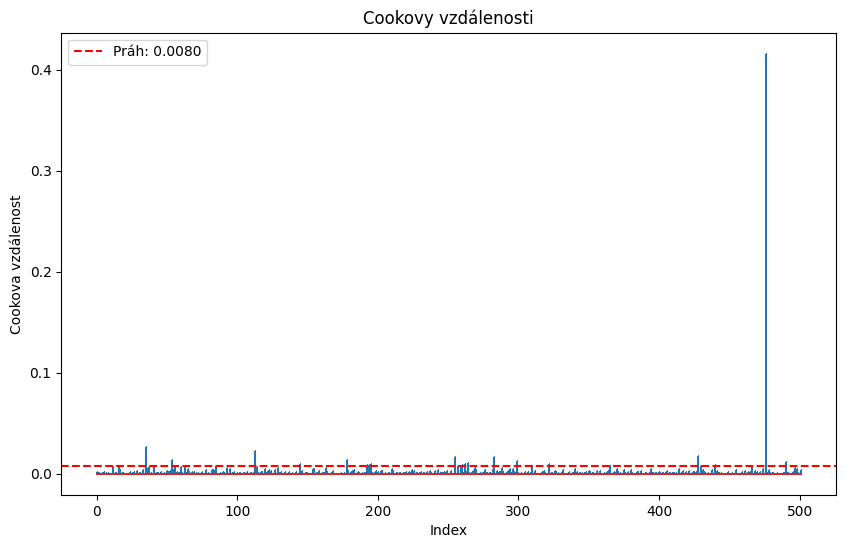

In [13]:
influence = OLSInfluence(model_standardized)
cooks_d = influence.cooks_distance[0]

threshold = 4 / len(data)  # Pravidlo: Cookovy vzdálenosti > 4/n jsou považovány za odlehlé
outliers = np.where(cooks_d > threshold)[0]

print(f"Počet odlehlých hodnot: {len(outliers)}")
print(f"Indexy odlehlých hodnot:")
print(cooks_d[outliers])

plt.figure(figsize=(10, 6))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.axhline(y=threshold, color='red', linestyle='--', label=f'Práh: {threshold:.4f}')
plt.title("Cookovy vzdálenosti")
plt.xlabel("Index")
plt.ylabel("Cookova vzdálenost")
plt.legend()

Během diagnostiky modelu bylo identifikováno 21 odlehlých hodnot, přičemž nejvýznamnější je záznam na indexu 476, který má nejvyšší Cookovu vzdálenost přesahující 0,4. Práh pro Cookovu vzdálenost byl stanoven na $\frac{4}{n}$, kde $n$ je počet pozorování, a hodnoty nad tímto prahem mohou výrazně ovlivnit model.

Cookova vzdálenost nám pomohla identifikovat odlehlé hodnoty, ale je potřeba posoudit, jak jejich přítomnost ovlivňuje koeficienty modelu.

1. Ověření vlivu odlehlých hodnot na koeficienty pomocí DFFITS a DFBETAS:

**DFFITS** ukazuje, jak se změní predikce, pokud vynecháme daný bod. **DFBETAS** ukazuje změnu odhadu koeficientu při vynechání bodu.

2. Výpočet DFFITS a DFBETAS:

Pokud některé hodnoty překročí stanovený práh, znamená to, že dané pozorování má významný vliv na model.


Počet odlehlých hodnot podle DFFITS: 21
Indexy odlehlých hodnot podle DFFITS: [ 35  54 113 145 178 192 194 195 255 259 260 262 264 283 299 322 365 428
 440 476 490]
Počet odlehlých hodnot podle DFBETAS: 363
Indexy odlehlých hodnot podle DFBETAS: [  0  12  12  16  16  16  16  17  17  17  17  17  27  27  33  33  35  35
  35  35  35  35  35  35  35  35  36  36  36  36  36  36  36  37  37  37
  41  41  41  41  52  54  54  54  54  54  54  54  54  54  55  56  56  56
  56  56  60  60  60  63  63  63  63  63  63  63  65  65  78  82  82  83
  83  83  84  85  85  85  85  93  93  93  93  93  95  95 113 113 113 113
 113 113 113 113 113 114 114 114 114 120 123 123 127 127 129 129 129 129
 142 145 145 145 145 154 154 154 155 155 155 163 163 168 168 168 178 178
 178 178 178 178 178 179 179 179 183 192 192 192 192 192 193 194 194 194
 194 194 195 195 195 195 203 210 210 210 210 211 224 241 241 243 249 249
 255 255 255 257 257 257 257 257 259 259 260 260 260 260 260 262 262 262
 262 262 262 262 262 262

Text(0, 0.5, 'DFBETAS')

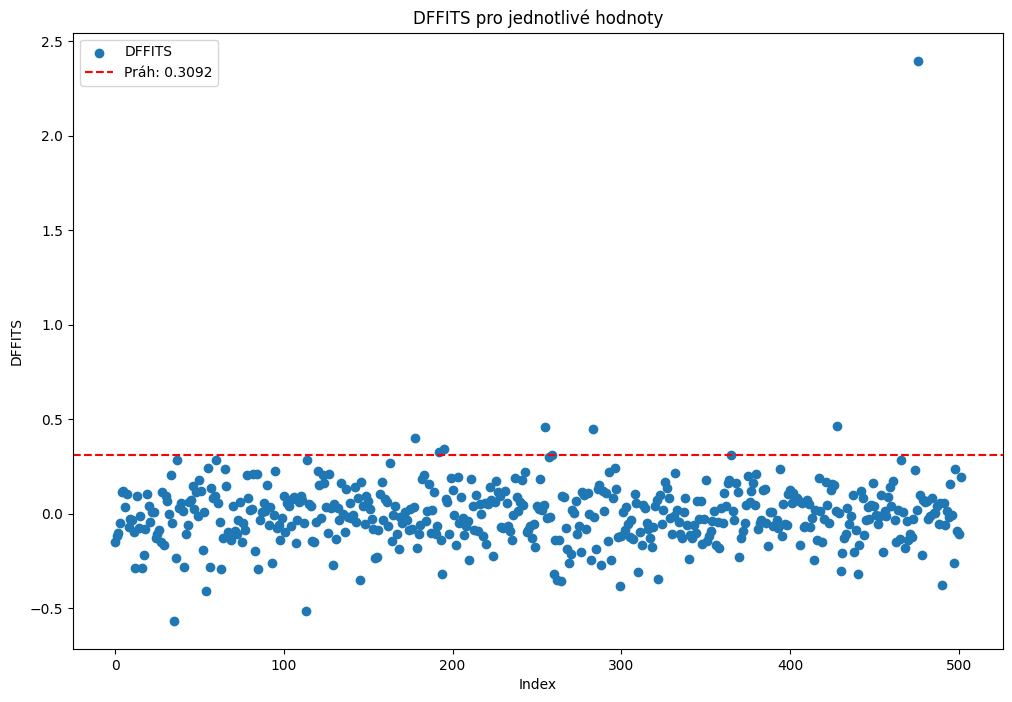

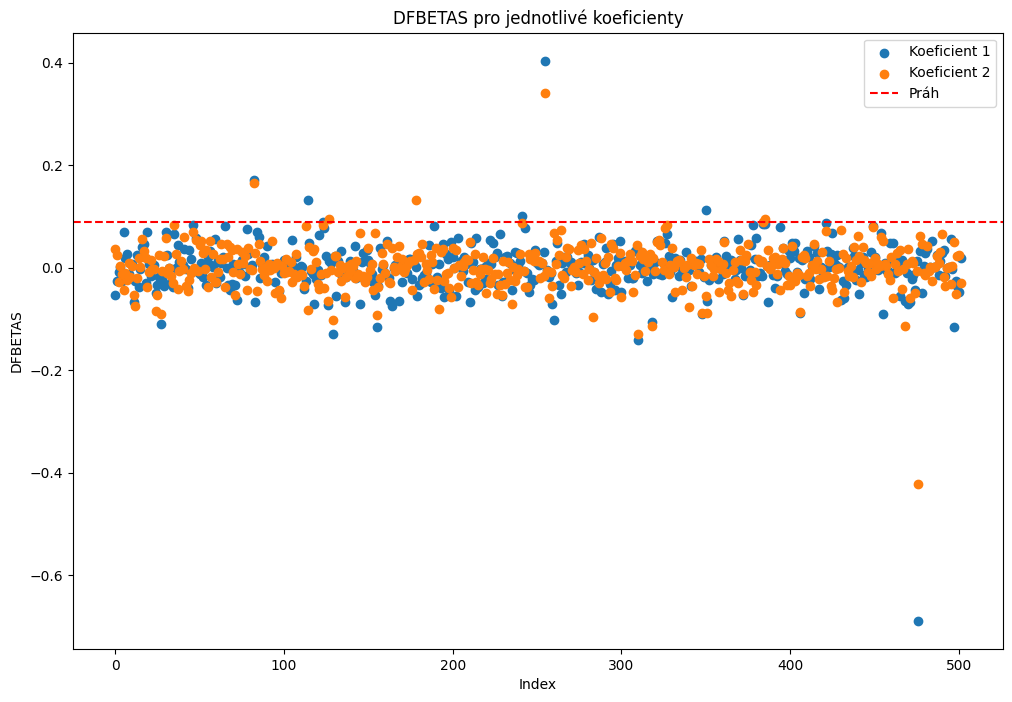

In [14]:
influence = OLSInfluence(model_standardized)

dffits = influence.dffits[0]
dfbetas = influence.dfbetas

p = X_standardized.shape[1]
n = len(data)

# Práh pro DFFITS: obvykle se používá 2 * sqrt(p/n), kde p je počet parametrů a n počet pozorování
dffits_threshold = 2 * np.sqrt(p / n)

# Práh pro DFBETAS: obvykle se používá 2 / sqrt(n)
dfbetas_threshold = 2 / np.sqrt(n)

influential_dffits = np.abs(dffits) > dffits_threshold
influential_dfbetas = np.abs(dfbetas) > dfbetas_threshold

print(f"Počet odlehlých hodnot podle DFFITS: {np.sum(influential_dffits)}")
print(f"Indexy odlehlých hodnot podle DFFITS: {np.where(influential_dffits)[0]}")

print(f"Počet odlehlých hodnot podle DFBETAS: {np.sum(influential_dfbetas)}")
print(f"Indexy odlehlých hodnot podle DFBETAS: {np.where(influential_dfbetas)[0]}")

# Vykreslení DFFITS pro každý index
plt.figure(figsize=(12, 8))
plt.scatter(np.arange(len(dffits)), dffits, label="DFFITS")
plt.axhline(dffits_threshold, color='red', linestyle='--', label=f'Práh: {dffits_threshold:.4f}')
plt.legend()
plt.title("DFFITS pro jednotlivé hodnoty")
plt.xlabel("Index")
plt.ylabel("DFFITS")

# Vykreslení DFBETAS pro každý koeficient
plt.figure(figsize=(12, 8))
plt.scatter(np.arange(len(dfbetas)), dfbetas[:, 0], label="Koeficient 1")
plt.scatter(np.arange(len(dfbetas)), dfbetas[:, 1], label="Koeficient 2")
plt.axhline(dfbetas_threshold, color='red', linestyle='--', label='Práh')
plt.legend()
plt.title("DFBETAS pro jednotlivé koeficienty")
plt.xlabel("Index")
plt.ylabel("DFBETAS")

Z grafu DFFITS vyplývá, že indexy 255, 283, 428 a 476 mají silný vliv na model, přičemž největší vliv má index 476. Analýza DFBETAS odhalila 363 odlehlých hodnot, přičemž nejvýraznější odchylky vykazují indexy 255 a 476. Ostatní hodnoty mají menší vliv.

Na základě těchto ukazatelů se doporučuje odstranit index 476, který má největší vliv na model, aby se zajistila stabilita a přesnost. Index 255 by měl být také odstraněn kvůli jeho extrémní odchylce v DFBETAS, což může ovlivnit koeficienty modelu. Ostatní odlehlé hodnoty neovlivňují model výrazně a mohou zůstat.

V následujících krocích odstraníme tyto hodnoty, data znovu standardizujeme a zhodnotíme model s odstraněnými odlehlými hodnotami.

In [15]:
data_cleaned = data_standardized.drop(index=[255, 476])

y, X_standardized = dmatrices(formula, data_cleaned, return_type='dataframe')
model_cleaned = sm.OLS(y, X_standardized).fit()

model_cleaned.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Q('Ping')   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     150.1
Date:                Sun, 15 Dec 2024   Prob (F-statistic):          9.13e-149
Time:                        22:04:48   Log-Likelihood:                 154.18
No. Observations:                 500   AIC:                            -284.4
Df Residuals:                     488   BIC:                            -233.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.0516      0.013      4.087      0.000       0.027       0.076
Windows                        0.0338      0.009      3.628      0.000       0.015       0.052
ActiveUsers                    0.6980      0.032     21.726      0.000       0.635       0.761
InteractingPct                 0.2389      0.028      8.574      0.000       0.184       0.294
Android:ActiveUsers            0.0676      0.023      2.962      0.003       0.023       0.113
Android:InteractingPct        -0.0170      0.020     -0.840      0.401      -0.057       0.023
MacOS:ActiveUsers              0.2170      0.022      9.935      0.000       0.174       0.260
MacOS:InteractingPct          -0.0001      0.018     -0.008      0.994      -0.036       0.036
Windows:ActiveUsers            0.0302      0.022      1.399      0.162      -0.012       0.073
Windows:InteractingPct        -0.0182      0.020     -0.916      0.360      -0.057       0.021
ActiveUsers:InteractingPct    -0.2211      0.027     -8.208      0.000      -0.274      -0.168
I(ActiveUsers ** 2)           -0.2962      0.032     -9.129      0.000      -0.360      -0.232
==============================================================================
Omnibus:                        0.063   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.969   Jarque-Bera (JB):                0.047
Skew:                           0.024   Prob(JB):                        0.977
Kurtosis:                       2.992   Cond. No.                         6.82
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Linearita + Normálnost reziduí**: Pro ověření linearity a normálnosti reziduí bylo provedeno vizuální hodnocení pomocí Q-Q grafu. Tento graf zobrazuje kvantily reziduí proti kvantily teoretického normálního rozdělení. Pokud jsou data normálně rozdělena, měly by body v Q-Q grafu ležet na přímce.

Na Q-Q grafu lze vidět, že po vyčištění dat (odstranění odlehlých hodnot a vlivných bodů) všechny body reziduí leží téměř přesně na přímce. Tento výsledek naznačuje, že rezidua jsou přibližně normálně rozdělena, což podporuje předpoklad o normalitě reziduí v rámci lineární regrese.

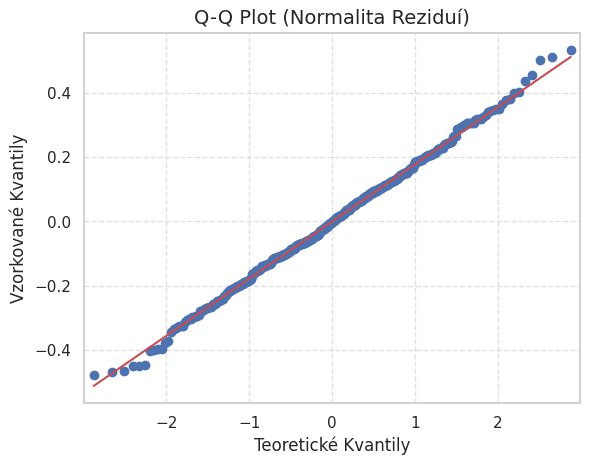

In [16]:
sns.set(style="whitegrid")
sm.qqplot(model_cleaned.resid, line='s') # Normálnost reziduí
plt.title("Q-Q Plot (Normalita Reziduí)", fontsize=14)
plt.xlabel("Teoretické Kvantily", fontsize=12)
plt.ylabel("Vzorkované Kvantily", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)

**Homoskedasticita**: Pro ověření homoskedasticity lze použít graf rozptylu reziduí vůči predikovaným hodnotám. V tomto grafu by měla být rezidua rovnoměrně rozložena kolem nuly bez jakýchkoli systematických vzorců. Pokud bychom pozorovali například vzrůstající nebo klesající trend v rozptylu, znamenalo by to porušení tohoto předpokladu.

Na přiloženém grafu rozptylu reziduí vůči predikovaným hodnotám lze pozorovat, že rozptyl reziduí je zhruba rovnoměrný kolem osy x, až na malou výchylku v rozmezí přibližně -0.3 až 0.3. Tato výchylka není dostatečně silná, aby narušila závěry o konstantním rozptylu. Tento výsledek naznačuje, že druhý předpoklad lineární regrese – homoskedasticita – je splněn.

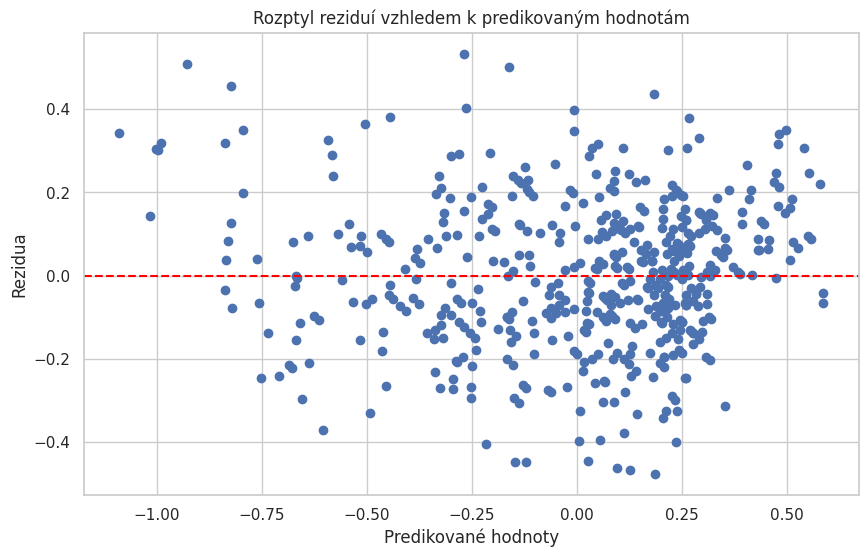

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(model_cleaned.fittedvalues, model_cleaned.resid)
plt.title("Rozptyl reziduí vzhledem k predikovaným hodnotám")
plt.xlabel("Predikované hodnoty")
plt.ylabel("Rezidua")
plt.axhline(y=0, color="red", linestyle="--")

### Pomocí Vašeho výsledného modelu identifikujte, pro které nastavení parametrů má odezva nejproblematičtější (největší) hodnotu (použijte model, nikoli samotná pozorování).

In [18]:
test_case = X.copy().iloc[0]
test_case['ActiveUsers'] = 200000
test_case['I(ActiveUsers ** 2)'] = test_case['ActiveUsers'] ** 2
test_case['iOS:ActiveUsers'] = test_case['ActiveUsers'] * test_case.get('iOS', 0)

# Zajistíme, že všechny sloupce, které model očekává, jsou ve `test_case`
# Pokud chybí nějaké sloupce, nastavíme je na nulu
missing_columns = set(X.columns) - set(test_case.index)
for col in missing_columns:
    test_case[col] = 0

test_case = test_case[X.columns]
predicted_response = model.predict(test_case.values.reshape(1, -1))[0]

predictions = model.predict(X)
index = abs(predictions - data['Ping']).argmax()

print(f"Predikovaná záporná odezva podle modelu: {predicted_response:.4f} ms\nPoužité parametry:")
print(test_case)

print(f"\nNejvětší rozdíl mezi predikcí a skutečnou hodnotou: {predictions[index]:.4f} ms\nPoužité parametry:")
print(X.iloc[index])

Predikovaná záporná odezva podle modelu: -15009.2533 ms
Použité parametry:
Intercept                     1.000000e+00
Windows                       0.000000e+00
ActiveUsers                   2.000000e+05
InteractingPct                8.283000e-01
Android:ActiveUsers           0.000000e+00
Android:InteractingPct        0.000000e+00
MacOS:ActiveUsers             0.000000e+00
MacOS:InteractingPct          0.000000e+00
Windows:ActiveUsers           0.000000e+00
Windows:InteractingPct        0.000000e+00
iOS:ActiveUsers               0.000000e+00
iOS:InteractingPct            8.283000e-01
ActiveUsers:InteractingPct    3.406798e+03
I(ActiveUsers ** 2)           4.000000e+10
Name: 0, dtype: float64

Největší rozdíl mezi predikcí a skutečnou hodnotou: 9.7935 ms
Použité parametry:
Intercept                         1.0000
Windows                           0.0000
ActiveUsers                     153.0000
InteractingPct                    0.2111
Android:ActiveUsers               0.0000
Android:Inte

### Odhadněte hodnotu odezvy uživatele s Windows, při průměrném nastavení ostatních parametrů a vypočtěte konfidenční interval a predikční interval pro toto nastavení.


In [19]:
windows_df = X[X['Windows'] == 1].mean()

predicted_response = model.predict(windows_df.values.reshape(1, -1))[0]
predictions = model.get_prediction(windows_df)
summary = predictions.summary_frame(alpha=0.05)

confidence_interval = summary.loc['Intercept', ['mean_ci_lower', 'mean_ci_upper']].values
prediction_interval = summary.loc['Intercept', ['obs_ci_lower', 'obs_ci_upper']].values

print(f"Odhadovaná odezva pro Windows: {predicted_response:.4f} ms")
print(f"Interval spolehlivosti: {confidence_interval}")
print(f"Predikční interval: {prediction_interval}")

Odhadovaná odezva pro Windows: 51.7164 ms
Interval spolehlivosti: [50.71032195 52.72251373]
Predikční interval: [40.02663998 63.4061957 ]


### Na základě jakýchkoli vypočtených charakteristik argumentujte, zdali je Váš model „vhodný“ pro další použití.

V druhém bodě této úlohy jsme zjistili, že model může generovat neplatné (záporné) hodnoty odezvy. Při vysokých hodnotách parametrů, jako je například velmi vysoký počet aktivních uživatelů (v tomto případě 200 000), model odhaduje záporné hodnoty odezvy. Tento problém ilustruje například predikce s hodnotou -15009.2533 ms, kde byla hodnota `ActiveUsers` nastavena na 200 000 a `I(ActiveUsers ** 2)` na 4e+10.

Tento typ výpočtu je nevhodný pro modelování odezvy pro populární sociální sítě, kde je běžné mít stovky tisíc aktivních uživatelů. V takových případech model často produkuje nereálné záporné odezvy, což znamená, že predikce nejsou smysluplné. To ukazuje, že model není dostatečně robustní pro práci s vysokými hodnotami vstupních parametrů a je třeba jej přizpůsobit pro širší spektrum hodnot.

V našem testovacím scénáři byla predikce pro populární síť (s 153 aktivními uživateli) mnohem rozumnější, s rozdílem mezi predikovanou hodnotou 9.7935 ms a skutečnou hodnotou, což ukazuje, že model je citlivý na počet uživatelů a nedokáže poskytovat spolehlivé výsledky pro velké sítě. Model tedy není vhodný pro predikci odezvy pro platformy s vysokým počtem uživatelů.